# RTOP-LA: Implementation with dummy node
Implementation of the model with the same formulation of the paper, using the dummy node.

In [1]:
# Libraries
import numpy as np
import gurobipy as gb
import matplotlib.pyplot as plt
import random
import networkx as nx 
import math
import re

## Building dummy artificial data

In [2]:
# Generete road costs
# c1: regular truck road cost
# c2: highway cost 
def generate_road_costs():
    c1 = random.uniform(100, 135) 
    c2 = c1 + c1*0.3  
    #return round(c1)/100, round(c2)/100
    # use the same values of the paper
    return 1, 1

# Example 
c1, c2 = generate_road_costs()
print("c1:", c1)
print("c2:", c2)


c1: 1
c2: 1


In [3]:
# generate random nodes
def generate_random_nodes(num_terminals, num_costumers):
    points = []
    for _ in range(num_terminals + num_costumers + 1):
        x = random.randint(0, 50)  
        y = random.randint(0, 50)  
        points.append((x, y))
    
    return points


# generate nodes with the same distribution of the paper
def generate_nodes_like_paper(num_costumers):
    points = []

    # The dummy points
    x = 0
    y = 0
    points.append((x,y))

    # The original terminal 
    x = random.randint(30, 50)  
    y = random.randint(0, 15) 
    points.append((x,y))

    # The first intermediate terminal
    x = random.randint(10, 35)  
    y = random.randint(20, 30) 
    points.append((x,y))

    # The second intermediate terminal
    x = random.randint(0, 25)  
    y = random.randint(30, 45) 
    points.append((x,y))

    # Costumers
    for _ in range(num_costumers):
        x = random.randint(0, 50)  
        y = random.randint(0, 50)  
        points.append((x, y))
    
    return points


# Example 
nodes_like_paper = generate_nodes_like_paper(num_costumers = 8)
print(nodes_like_paper)

[(0, 0), (44, 3), (30, 21), (15, 32), (13, 20), (50, 11), (33, 17), (15, 0), (31, 19), (17, 14), (30, 20), (20, 12)]


[(0, 0), (37, 15), (25, 28), (3, 44), (36, 8), (48, 21), (46, 26), (44, 17), (40, 28)]


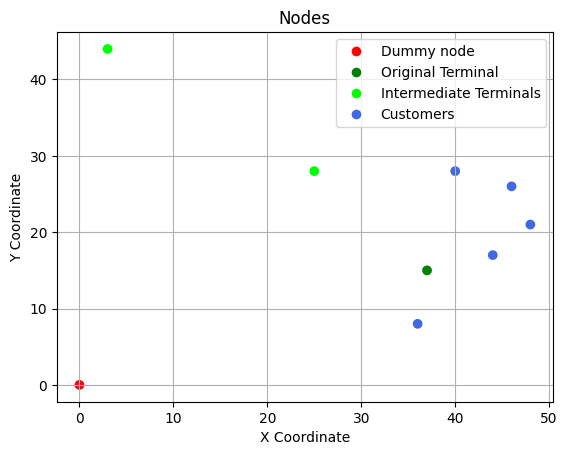

In [4]:
# Plot nodes
def plot_nodes(nodes, num_terminals):
    x_coords = [point[0] for point in nodes]
    y_coords = [point[1] for point in nodes]

    colors = ['red'] * 1 + ['green'] * 1 + ['lime'] * (num_terminals - 1) + ['royalblue'] * (len(nodes) - (num_terminals + 1))
    
    plt.scatter(x_coords, y_coords, color=colors)
    plt.title('Nodes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)

    # Create the legend
    legend_labels = ['Dummy node', 'Original Terminal', 'Intermediate Terminals', 'Customers']
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color, markersize=8)
                      for label_color in ['red', 'green', 'lime', 'royalblue']]
    plt.legend(legend_handles, legend_labels)

    plt.show()


# Example 
num_terminals = 3
num_costumers = 5
nodes = generate_nodes_like_paper(num_costumers = num_costumers)
print(nodes)
plot_nodes(nodes = nodes, num_terminals = 3)

In [5]:
# Matrix of distances between each nodes
def compute_distance_matrix(nodes, num_terminals):
    num_nodes = len(nodes)
    distance_matrix = [np.zeros((num_nodes, num_nodes)) for _ in range(num_terminals) for _ in range(num_terminals)]
    for t in range(num_terminals):
        for i in range(num_nodes):
            for j in range(num_nodes):
                x1, y1 = nodes[i]
                x2, y2 = nodes[j]
                if i==0: x1, y1 = nodes[t+1]
                if j==0: x2, y2 = nodes[t+1]
                distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                distance_matrix[t][i][j] = round(distance,2)
    return distance_matrix

# Build road cost matrix
def compute_road_cost_matrix(distance_matrix, c1, c2, num_terminals):
    road_cost_matrix = [np.zeros((len(distance_matrix[0]),len(distance_matrix[0]))) for _ in range(num_terminals)]
    for t in range(num_terminals):
        for i in range(len(distance_matrix[0])):
            for j in range(len(distance_matrix[0])):
                # Highway case
                if (i == 1 and j != 0 and j < num_terminals + 1) or (j == 1 and i != 0 and i < num_terminals + 1):
                    road_cost_matrix[t][i][j] = round(distance_matrix[t][i][j] * c2,2)
                # Standard road case
                else:
                    road_cost_matrix[t][i][j] = round(distance_matrix[t][i][j] * c1,2)
    return road_cost_matrix

# Extract highway costs# There is also the cost original terminal - original terminal track
def exctract_highway_costs(road_cost_matrix, num_terminals):
    highway_cost = [road_cost_matrix[t][1][0 : num_terminals + 1] for t in range(num_terminals)]
    return highway_cost


# Example 
distance_matrix = compute_distance_matrix(nodes, num_terminals)
for t in range(num_terminals):
    for row in distance_matrix[t][:][:]:
        print(row)
    print()
print()

road_cost_matrix = compute_road_cost_matrix(distance_matrix, c1,c2, num_terminals)
for t in range(num_terminals):
    for row in road_cost_matrix[t][:][:]:
        print(row)
    print()
print()

highway_costs = exctract_highway_costs(road_cost_matrix, num_terminals)
print(highway_costs[0])

[ 0.    0.   17.69 44.69  7.07 12.53 14.21  7.28 13.34]
[ 0.    0.   17.69 44.69  7.07 12.53 14.21  7.28 13.34]
[17.69 17.69  0.   27.2  22.83 24.04 21.1  21.95 15.  ]
[44.69 44.69 27.2   0.   48.84 50.54 46.62 49.09 40.31]
[ 7.07  7.07 22.83 48.84  0.   17.69 20.59 12.04 20.4 ]
[12.53 12.53 24.04 50.54 17.69  0.    5.39  5.66 10.63]
[14.21 14.21 21.1  46.62 20.59  5.39  0.    9.22  6.32]
[ 7.28  7.28 21.95 49.09 12.04  5.66  9.22  0.   11.7 ]
[13.34 13.34 15.   40.31 20.4  10.63  6.32 11.7   0.  ]

[ 0.   17.69  0.   27.2  22.83 24.04 21.1  21.95 15.  ]
[17.69  0.   17.69 44.69  7.07 12.53 14.21  7.28 13.34]
[ 0.   17.69  0.   27.2  22.83 24.04 21.1  21.95 15.  ]
[27.2  44.69 27.2   0.   48.84 50.54 46.62 49.09 40.31]
[22.83  7.07 22.83 48.84  0.   17.69 20.59 12.04 20.4 ]
[24.04 12.53 24.04 50.54 17.69  0.    5.39  5.66 10.63]
[21.1  14.21 21.1  46.62 20.59  5.39  0.    9.22  6.32]
[21.95  7.28 21.95 49.09 12.04  5.66  9.22  0.   11.7 ]
[15.   13.34 15.   40.31 20.4  10.63  6.32 11.7

In [6]:
# Generate trailer capacity Q
def generate_trailer_capacity(min_value = 24, max_value = 24):
    trailer_capacity = random.randint(min_value, max_value)
    return trailer_capacity

# Example 
trailer_capacity = generate_trailer_capacity()
print(trailer_capacity)


24


In [7]:
# Generate number of experienced drivers
def generate_number_experienced_drivers(min_value = 5, max_value = 15):
    number_experienced_drivers = random.randint(min_value, max_value)
    return number_experienced_drivers

# Example 
number_experienced_drivers = generate_number_experienced_drivers()
print(number_experienced_drivers)

13


In [8]:
# Generate costumer demands
# It depends on capacity since costumer demand <= capacity
def generate_costumer_demands(capacity_Q, num_costumers):
    costumer_demands = np.zeros(num_costumers)
    for i in range(num_costumers):
        costumer_demands[i] = random.randint(0, capacity_Q)
    return costumer_demands

# generate the demands with the same distribution of the paper, distinguishing between LT orders 
# and LTL orders (with high demand pattern -> qj in [4,5,6], or low demand pattern -> qj in [7,8,9])
def generate_costumer_demands_like_paper(num_costumers, LTL_orders, LTL_pattern, num_terminals = 3):
    costumer_demands = np.zeros(num_costumers+num_terminals+1)
    for i in range(num_terminals+1, num_costumers+num_terminals+1-LTL_orders):
        costumer_demands[i] = 24
    for i in range(num_costumers+num_terminals+1-LTL_orders, num_costumers+num_terminals+1):
        if (LTL_pattern == 'L'): costumer_demands[i] = random.randint(4,6)
        elif (LTL_pattern == 'H'): costumer_demands[i] = random.randint(7,9)
        else: print('LTL_patter must be equal to H for high demand patter or L for low demand patter')
    return costumer_demands

# Example
random_costumer_demands = generate_costumer_demands(capacity_Q=trailer_capacity, num_costumers=8)
print(random_costumer_demands)
paper_costumer_demands = generate_costumer_demands_like_paper(num_costumers=num_costumers, LTL_orders = 4, LTL_pattern = 'H', num_terminals = 3)
print(paper_costumer_demands)

[ 2. 10.  3. 14. 18. 16. 11.  0.]
[ 0.  0.  0.  0. 24.  8.  9.  9.  8.]


In [9]:
# Powerset function
def powerset(s):
    power_set = [[]]
    for element in s:
        new_subsets = [subset + [element] for subset in power_set]
        power_set.extend(new_subsets)
    return power_set

# Powerset function with one difference
# It does not return elements as [] or element with a 0 inside
def powerset_without_emptyset(s):
    power_set = [[]]
    for element in s:
        new_subsets = [subset + [element] for subset in power_set if element != 0]
        power_set.extend(new_subsets)
    power_set = [x for x in power_set if x != []]
    return power_set

# Example usage
my_set = [4, 5, 6]
result = powerset(my_set)
print(result)
result = powerset_without_emptyset(my_set)
print(result)


[[], [4], [5], [4, 5], [6], [4, 6], [5, 6], [4, 5, 6]]
[[4], [5], [4, 5], [6], [4, 6], [5, 6], [4, 5, 6]]


In [10]:
# Given an array of data, it divides and return the different kinds of data 
def extract_data(filename):
    LTL_orders = int(filename[7])
    LTL_pattern = filename[9]
    filename = "./dataset/" + filename
    FILE = open(filename, 'r')
    lines = FILE.read().strip().split("\n")
    input_data = [list(map(int, re.findall(r'\d+', line))) for line in lines]
    num_costumers =             input_data[0][0]
    num_terminals =             input_data[0][1]
    Q =                         input_data[0][2]
    c1 =                        input_data[0][3]/10
    c2 =                        input_data[0][4]/10
    num_experienced_drivers =   input_data[0][5]
    costumers_data = [row[1:3] for row in input_data[1: num_costumers + 1]]
    terminals_data = [row[1:3] for row in input_data[num_costumers + 1: num_costumers + num_terminals + 2]]
    dummy_data = [[0, 0]]
    nodes = dummy_data + terminals_data + costumers_data
    #print(nodes)
    q = [0,0,0,0] + [row[3] for row in input_data[1: num_costumers + 1]]
    FILE.close()
    return  num_costumers, num_terminals, Q, c1, c2, num_experienced_drivers, nodes, q, LTL_orders, LTL_pattern

## Solving the problem

In [11]:
# Model
train_model = gb.Model()
train_model.modelSense = gb.GRB.MINIMIZE

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-25


In [12]:
# for loading the configuration of the original paper dataset:
filename = "TL8_LTL4_H_D.txt"
num_costumers, num_terminals, trailer_capacity, c1 , c2 , number_experienced_drivers, nodes, costumer_demands, LTL_orders, LTL_pattern = extract_data(filename)
number_of_trailers = 53 # following the paper

print(num_costumers, num_terminals, trailer_capacity, c1 , c2 , number_experienced_drivers, nodes, costumer_demands)

12 3 24 1.0 1.0 10 [[0, 0], [47, 4], [16, 27], [0, 38], [16, 37], [26, 20], [2, 24], [18, 15], [13, 47], [18, 37], [34, 8], [11, 16], [48, 46], [30, 25], [29, 28], [11, 46]] [0, 0, 0, 0, 24, 24, 24, 24, 24, 24, 24, 24, 9, 8, 7, 8]


In [13]:
# generate the configuration (randomly, but with the same distributions of the paper)

#number_of_trailers = 53 # following the paper
#c1, c2 = generate_road_costs()
#num_terminals = 3
#num_costumers = 12
#LTL_orders = 6
#LTL_pattern = 'L'
#nodes = generate_nodes_like_paper(num_costumers)
#trailer_capacity = generate_trailer_capacity(min_value=24, max_value=24)
#number_experienced_drivers = generate_number_experienced_drivers(min_value=10, max_value=15)
#costumer_demands =  generate_costumer_demands_like_paper(num_costumers, LTL_orders=LTL_orders, 
#                    LTL_pattern=LTL_pattern, num_terminals=num_terminals)


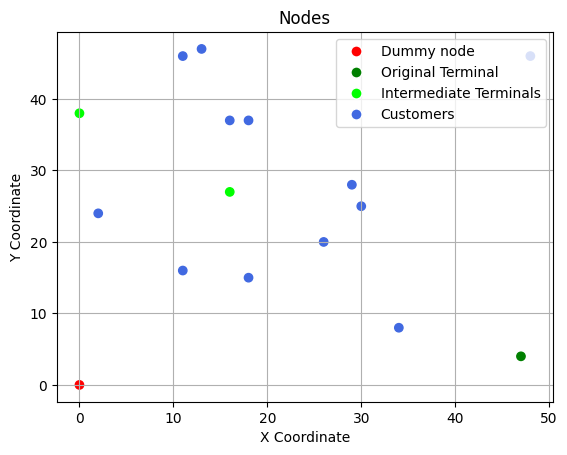

In [14]:
plot_nodes(nodes=nodes, num_terminals=num_terminals)

In [15]:
# compute the matrices of distances
distance_matrix = compute_distance_matrix(nodes, num_terminals)
road_cost_matrix = compute_road_cost_matrix(distance_matrix, c1,c2, num_terminals)
highway_costs = exctract_highway_costs(road_cost_matrix, num_terminals)

# Introduce a simple (paper coherent notation)
# extract from the road-cost matrix the elements of interest, according to the indices of the sets defined below:
c = road_cost_matrix
c_bar = highway_costs
r = number_experienced_drivers
Q = trailer_capacity
q = costumer_demands

print(r,Q,q)

10 24 [0, 0, 0, 0, 24, 24, 24, 24, 24, 24, 24, 24, 9, 8, 7, 8]


In [16]:
# Introduced variables
 
J = range(num_terminals+1,num_costumers+num_terminals+1)
# the set V starts from 0 because it contains the dummy node 0
V = [0]+[j for j in J]
T = range(1, num_terminals+1)
K = range(1, number_of_trailers+1)

#print(list(J))
#print(list(V))
#print(list(T))
#print(list(T[1:]))
#print(list(K))

In [17]:
# Add the decision variables to the model:

x = train_model.addVars(
    [(i, j, t, k) for t in T for k in K for i in V for j in J if(i < j)],
    vtype = gb.GRB.INTEGER,
    # specify that values are in {0,1,2} 
    lb = 0,
    ub = 2
)

w = train_model.addVars(
    [t for t in T[1:]],
    vtype=gb.GRB.INTEGER,
    lb = 0,
    ub = number_experienced_drivers
)

y = train_model.addVars(
    [(t,k) for t in T for k in K], 
    vtype = gb.GRB.BINARY
)

z = train_model.addVars(
    [(t,k,j) for t in T for k in K for j in J], 
    vtype = gb.GRB.BINARY
)

In [18]:
# Set the objective function:
train_model.setObjective(
    gb.quicksum(c[t-1][i, j] * x[i, j, t, k] for k in K for t in T for i in V for j in J if(i < j)) +
    gb.quicksum(c_bar[0][t] * w[t] for t in T[1:])
)

In [19]:
# Add constraints

# Constraint 1: \sum_{t \in T \setminus \{1\}} w_t <= r
train_model.addConstr(
    gb.quicksum(w[t] for t in T[1:]) <= r
)

# Constraint 2: \sum_{k \in K} y_{tk} = 2 w_t \hspace{1em} \forall t \in T \setminus \{1\}
for t in T[1:]:
    train_model.addConstr(
        gb.quicksum(y[t, k] for k in K) == 2 * w[t] 
    )

# Constraint 3: \sum_{t \in T} y_{tk} <= 1 \hspace{1em} \forall k\in K
for k in K:
    train_model.addConstr(
        gb.quicksum(y[t, k] for t in T) <= 1
    )

# Constraint 4: \sum_{j \in J} q_j z_{tkj} <= Q y_{tk} \hspace{1em} \forall k \in K \hspace{1em} \forall t \in T
for k in K:
    for t in T:
        train_model.addConstr(
            gb.quicksum(q[j] * z[t, k, j] for j in J) <= Q * y[t, k]
        )

# Constraint 5: \sum_{t \in T} \sum_{k \in K} z_{tkj} = 1 \hspace{1em} \forall j \in J
for j in J:
    train_model.addConstr(
        gb.quicksum(z[t, k, j] for t in T for k in K) == 1
    )

# Constraint 6: \sum_{i \in V \text{ and } i<j} x_{ijtk} + \sum_{i \in V \text{ and } i>j } x_{jitk} = 2 z_{tkj} 
#               \hspace{1em}\forall j  \in J \hspace{1em} \forall t \in T \hspace{1em} \forall k \in K
for j in J:
    for t in T:
        for k in K:
            train_model.addConstr(
                gb.quicksum(x[i, j, t, k] for i in V if(i < j)) +
                gb.quicksum(x[j, i, t, k] for i in V if(i > j)) == 2 * z[t, k, j]
            )

# Constraint 7: \sum_{j \in J} x_{0jtk} = 2y_{tk} \hspace{1em} \forall k \in K \hspace{1em} \forall t \in T
for k in K:
    for t in T:
        train_model.addConstr(
            gb.quicksum(x[0, j, t, k] for j in J) == 2 * y[t, k]
        )

# Constraint 8:     \sum_{i \in S} \sum_{j \in S \text{ and } i < j} x_{ijkt} \leq |S| - 1 
#                   \hspace{1em} \forall S \subseteq J \hspace{1em} \forall k \in K \hspace{1em} \forall t \in  T
for S in powerset_without_emptyset(J):
    if (sum(q[j] for j in S)<Q):
        for t in T:
            for k in K:
                train_model.addConstr(
                    gb.quicksum(x[i, j, t, k] for i in S for j in S if(i < j)) <= len(S) - 1
                )

In [20]:
# Find the optimal solution:

train_model.optimize()

print()
print("x[i,j,t,k], (i,j), t, k")
for k in K:
    for t in T:
        for j in J:
            for i in V:
                if (i < j):
                    if(x[i,j,t,k].x != 0): print(x[i,j,t,k].x, (i,j), t, k)
print()

print("q[j]")
for j in J:
    print(q[j])
print()

print("w[t]")
for t in T[1:]:
    print(w[t].x)
print()

print("if (y[t,k] != 0) -> (t,k)")
for k in K:
    for t in T:
        if (y[t,k].x != 0): print((t,k))
print()

print("if (z[t,k,j] != 0) -> (t,k,j)")
for k in K:
    for t in T:
        for j in J:
            if (z[t,k,j].x != 0): print(t,k,j)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 12th Gen Intel(R) Core(TM) i7-1270P, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 4043 rows, 14471 columns and 32546 nonzeros
Model fingerprint: 0xc7e30e65
Variable types: 0 continuous, 14471 integer (2067 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e+00, 6e+01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 2862 rows and 10812 columns
Presolve time: 0.19s
Presolved: 1181 rows, 3659 columns, 9968 nonzeros
Variable types: 0 continuous, 3659 integer (3021 binary)

Root relaxation: objective 4.690117e+02, 2084 iterations, 0.02 seconds (0.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  469.01167    0   18          -  469.0

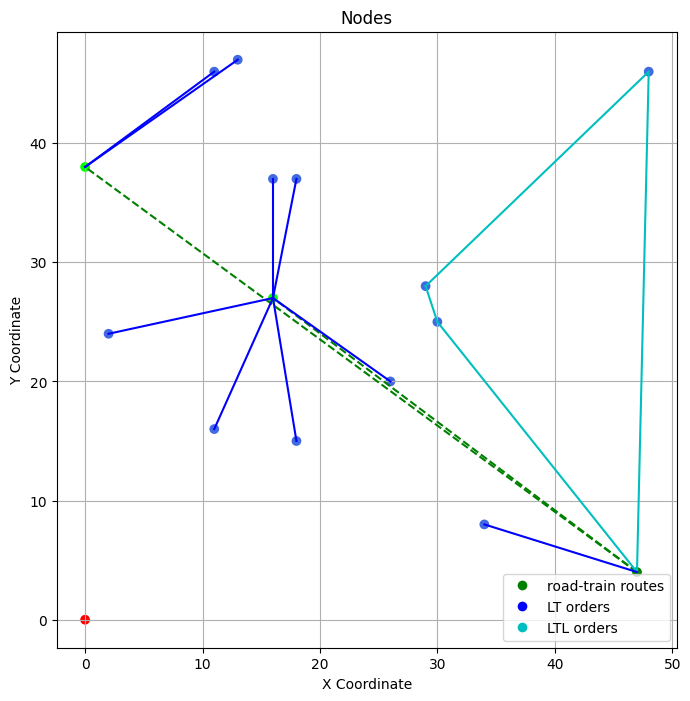

In [21]:
# Plot optimal solution
def plot_solution(nodes, x, w, q, num_terminals = 3):
    x_coords = [point[0] for point in nodes]
    y_coords = [point[1] for point in nodes]

    # set the colors for each node:
    # red: dummy node
    # green: original terminal; lime: secondary terminals
    # blue: costumers
    colors = ['red'] * 1 + ['green'] * 1 + ['lime'] * (num_terminals - 1) + ['royalblue'] * (len(nodes) - (num_terminals + 1))
    
    plt.figure(figsize=(8,8))
    plt.scatter(x_coords, y_coords, color=colors)
    plt.title('Nodes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)

    # draw the routes of the road trains (between original terminal and secondary terminals), 
    # if they exist (green dashed lines)
    for t in T[1:]:
        if (w[t].x != 0): plt.plot((x_coords[1],x_coords[t]), (y_coords[1],y_coords[t]), 'g--')

    # draw the regular trucks routes (between terminals and customers), distinguishing between LT orders 
    # and LTL orders (with high or low pattern) (blue/light blue continuous lines)
    for k in K:
        for t in T:
            for j in J:
                for i in V:
                    if (i < j):
                        i_, j_ = i, j
                        if i==0: i_ = t
                        if j==0: j_ = t
                        # blue color for LT orders
                        if(x[i,j,t,k].x == 2): plt.plot((x_coords[i_],x_coords[j_]), (y_coords[i_],y_coords[j_]), 'b-')
                        # light blue color for LTL orders
                        if(x[i,j,t,k].x == 1): plt.plot((x_coords[i_],x_coords[j_]), (y_coords[i_],y_coords[j_]), 'c-')

    # Create the legend
    #legend_labels = ['Dummy node', 'Original Terminal', 'Intermediate Terminals', 'Customers']
    #legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color, markersize=8)
    #                  for label_color in ['red', 'green', 'lime', 'royalblue']]
    legend_labels =     ['road-train routes', 'LT orders', 'LTL orders']
    legend_handles =    [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=label_color, markersize=8)
                        for label_color in ['g', 'b', 'c']]
    plt.legend(legend_handles, legend_labels, loc = 'best')
    filename = 'GI_LT{TL}_LTL{LTL}_{pattern}_T{T}'.format(TL=num_costumers-LTL_orders, LTL=LTL_orders, pattern=LTL_pattern, T=num_terminals)
    plt.savefig(filename+'.png')
    plt.show()

# save the instance/configuration of the problem (eventually to reproduce the results)
def save_instance(nodes, q, r, Q, c1, c2, num_costumers, LTL_orders, LTL_pattern, num_terminals = 3):
    filename = 'GI_LT{TL}_LTL{LTL}_{pattern}_T{T}'.format(TL=num_costumers-LTL_orders, LTL=LTL_orders, pattern=LTL_pattern, T=num_terminals)
    FILE = open(filename, 'w')
    FILE.write( '{r}  {Q}  {c1}  {c2}  {num_costumers}  {TL}  {LTL}  {pattern}  {T}'.format(
                r=r, Q=Q, c1=c1, c2=c2, num_costumers=num_costumers, TL=num_costumers-LTL_orders, 
                LTL=LTL_orders, pattern=LTL_pattern, T=num_terminals))
    FILE.write("\n\n")
    for point in nodes:
        FILE.write('{x}  {y}\n'.format(x=point[0], y=point[1]))
    FILE.write("\n")
    for j in range(num_terminals+1, len(nodes)):
        FILE.write('{q}  '.format(q=q[j]))
    FILE.close()


save_instance(nodes, q, r, Q, c1, c2, num_costumers, LTL_orders, LTL_pattern, num_terminals)
plot_solution(nodes = nodes, x = x, w = w, q = q)